In [1]:
#imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from math import sqrt
from hyperopt import hp
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from catboost import CatBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.hyperopt_model import HyperoptModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr,  spearmanr,  kendalltau

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read the data
preprocessed_data = pd.read_pickle('../data/preprocessed_science_quantitative.pd')

# Create a dataframe
df = pd.DataFrame(preprocessed_data)

In [ ]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test=train_test_split(df, test_size=0.2, random_state=0)

In [4]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 79342
Number of observations in the test data: 19836


Cross-validated scores: [ 0.78460898  0.7801021   0.78162625  0.78919265]
Average R^2 score: 0.783882493024


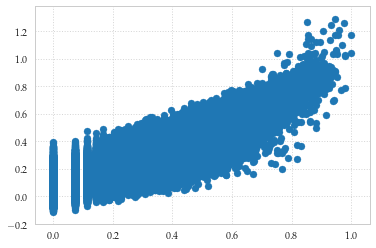

R2Score: 0.784134612582
RMSE: 0.09299797356587272


In [5]:
# Linear Regression 
dfLinear = df.copy()
y = dfLinear['score'].copy()
dfLinear.drop('score', axis=1, inplace=True) 

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(dfLinear, y, test_size=0.2)

model = linear_model.LinearRegression()

scores = cross_val_score(model, dfLinear, y, cv=4)
print("Cross-validated scores:", scores)
print("Average R^2 score:", scores.mean())

predictions = cross_val_predict(model, dfLinear, y, cv=4)
plt.scatter(y, predictions)
plt.show()

accuracy = metrics.r2_score(y, predictions)
print("R2Score:", accuracy)
rmse = sqrt(metrics.mean_squared_error(y,  predictions))
print("RMSE:", rmse)

In [6]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Lasso Regression with hyperopt optimization
    lasso = HyperoptModel(train.copy(), test.copy(),'lasso', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')

    lasso.pipeline = Pipeline([
        ('estimate', linear_model.Lasso(**{'alpha': 0.0006577184991258585}))
    ])
    
    lasso.raw_features = features
    lasso.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 10),
    }

    if hyperopt:
        lasso.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lasso.pipeline.fit(X=lasso.X_train, y=lasso.y_train)
        lasso.model = lasso.pipeline
        lasso.stats()
        lasso.plot_feature_importance()
        lasso.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        lasso.qq_plot()

Stats (train | test):
	R^2 score:		0.7704
					0.7731
	RMSE:			0.0960
					0.0952
	Mean error:		0.0755
					0.0748
	Pearson:		0.8780
					0.8797
	Spearman:		0.8480
					0.8515
	KendallTau:		0.6749
					0.6785

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [7]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Ridge Regression with hyperopt optimization
    ridge = HyperoptModel(train.copy(), test.copy(),'ridge', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')
    ridge.raw_features = features

    ridge.pipeline = Pipeline([
        ('estimate', linear_model.Ridge(**{'alpha': 0.05231780585024858}))
    ])
    
    ridge.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 1000),
    }

    if hyperopt:
        ridge.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        ridge.pipeline.fit(X=ridge.X_train, y=ridge.y_train)
        ridge.model = ridge.pipeline
        ridge.stats()
        ridge.plot_feature_importance()
        ridge.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        ridge.qq_plot()

Stats (train | test):
	R^2 score:		0.7841
					0.7855
	RMSE:			0.0930
					0.0926
	Mean error:		0.0726
					0.0721
	Pearson:		0.8855
					0.8863
	Spearman:		0.8519
					0.8542
	KendallTau:		0.6810
					0.6833

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [8]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run MLPRegressor with hyperopt optimization
    nn = HyperoptModel(train.copy(), test.copy(),'nn', cv=3, max_evals=500)
    features = list(df)
    features.remove('score')
    nn.raw_features = features

    nn.pipeline = Pipeline([
        ('estimate', MLPRegressor())
    ])
   
    nn.space = {
         'estimate__alpha' : hp.uniform('estimate__alpha', 0.001, 1),
         'estimate__activation' : hp.choice('estimate__activation', ['logistic']), # 'identity', 'logistic', 'tanh', 'relu'
         #'estimate__learning_rate' : hp.choice('estimate__learning_rate', ['constant', 'invscaling', 'adaptive']),
         'estimate__hidden_layer_sizes' : scope.int(hp.uniform('estimate__hidden_layer_sizes', 1, 100)),
         'estimate__solver' : hp.choice('estimate__solver', ['adam']), #'lbfgs', 'sgd',
         #'estimate__max_iter' : scope.int(hp.uniform('estimate__max_iter', 500, 1000))
    }

    if hyperopt:
        nn.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        nn.pipeline.fit(X=nn.X_train, y=nn.y_train)
        nn.model = cat.pipeline
        nn.stats()
        nn.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        nn.plot_feature_importance()
        nn.qq_plot()

Performing parameters optimization...
[1/500]	cv_eval_time=20.16 sec	RMSE=0.103636	R^2=0.733990
[2/500]	cv_eval_time=18.69 sec	RMSE=0.102362	R^2=0.738322
[3/500]	cv_eval_time=29.79 sec	RMSE=0.097974	R^2=0.761743
[4/500]	cv_eval_time=21.53 sec	RMSE=0.107053	R^2=0.712138
[5/500]	cv_eval_time=22.62 sec	RMSE=0.099593	R^2=0.754501
[6/500]	cv_eval_time=29.76 sec	RMSE=0.098018	R^2=0.756001
[7/500]	cv_eval_time=29.80 sec	RMSE=0.098258	R^2=0.759259
[8/500]	cv_eval_time=40.10 sec	RMSE=0.099237	R^2=0.756856
[9/500]	cv_eval_time=57.23 sec	RMSE=0.099236	R^2=0.753076
[10/500]	cv_eval_time=54.17 sec	RMSE=0.106669	R^2=0.722313
[11/500]	cv_eval_time=50.94 sec	RMSE=0.109590	R^2=0.691730
[12/500]	cv_eval_time=44.72 sec	RMSE=0.109566	R^2=0.705091
[13/500]	cv_eval_time=38.64 sec	RMSE=0.110986	R^2=0.696441
[14/500]	cv_eval_time=38.42 sec	RMSE=0.108100	R^2=0.707359
[15/500]	cv_eval_time=45.33 sec	RMSE=0.104062	R^2=0.729208
[16/500]	cv_eval_time=45.48 sec	RMSE=0.097808	R^2=0.762550
[17/500]	cv_eval_time=46.02

[139/500]	cv_eval_time=56.64 sec	RMSE=0.095733	R^2=0.768347
[140/500]	cv_eval_time=47.66 sec	RMSE=0.097649	R^2=0.761879
[141/500]	cv_eval_time=57.36 sec	RMSE=0.096458	R^2=0.768731
[142/500]	cv_eval_time=49.67 sec	RMSE=0.101457	R^2=0.741995
[143/500]	cv_eval_time=50.29 sec	RMSE=0.098657	R^2=0.760239
[144/500]	cv_eval_time=46.61 sec	RMSE=0.097607	R^2=0.763742
[145/500]	cv_eval_time=38.67 sec	RMSE=0.110345	R^2=0.703559
[146/500]	cv_eval_time=23.66 sec	RMSE=0.096529	R^2=0.768795
[147/500]	cv_eval_time=42.55 sec	RMSE=0.095706	R^2=0.771660
[148/500]	cv_eval_time=30.50 sec	RMSE=0.095365	R^2=0.772314
[149/500]	cv_eval_time=54.65 sec	RMSE=0.096082	R^2=0.767286
[150/500]	cv_eval_time=54.92 sec	RMSE=0.096992	R^2=0.766054
[151/500]	cv_eval_time=40.26 sec	RMSE=0.095759	R^2=0.771391
[152/500]	cv_eval_time=29.71 sec	RMSE=0.095544	R^2=0.773754
[153/500]	cv_eval_time=39.62 sec	RMSE=0.096445	R^2=0.764820
[154/500]	cv_eval_time=59.41 sec	RMSE=0.095704	R^2=0.771572
[155/500]	cv_eval_time=51.26 sec	RMSE=0.

[275/500]	cv_eval_time=78.76 sec	RMSE=0.095518	R^2=0.773039
[276/500]	cv_eval_time=56.67 sec	RMSE=0.097183	R^2=0.764773
[277/500]	cv_eval_time=126.43 sec	RMSE=0.096569	R^2=0.763690
[278/500]	cv_eval_time=68.06 sec	RMSE=0.095965	R^2=0.768204
[279/500]	cv_eval_time=47.13 sec	RMSE=0.095473	R^2=0.772279
[280/500]	cv_eval_time=42.28 sec	RMSE=0.095209	R^2=0.773655
[281/500]	cv_eval_time=127.72 sec	RMSE=0.096730	R^2=0.762731
[282/500]	cv_eval_time=219.63 sec	RMSE=0.096893	R^2=0.763177
[283/500]	cv_eval_time=242.44 sec	RMSE=0.097954	R^2=0.764660
[284/500]	cv_eval_time=265.02 sec	RMSE=0.094733	R^2=0.774376
[285/500]	cv_eval_time=347.06 sec	RMSE=0.098001	R^2=0.767342
[286/500]	cv_eval_time=359.89 sec	RMSE=0.095732	R^2=0.772420
[287/500]	cv_eval_time=279.03 sec	RMSE=0.097894	R^2=0.756239
[288/500]	cv_eval_time=380.55 sec	RMSE=0.097434	R^2=0.769386
[289/500]	cv_eval_time=336.78 sec	RMSE=0.097451	R^2=0.769675
[290/500]	cv_eval_time=354.99 sec	RMSE=0.095644	R^2=0.758465
[291/500]	cv_eval_time=332.74

[411/500]	cv_eval_time=58.86 sec	RMSE=0.096886	R^2=0.765588
[412/500]	cv_eval_time=56.05 sec	RMSE=0.095084	R^2=0.771074
[413/500]	cv_eval_time=50.74 sec	RMSE=0.094835	R^2=0.774538
[414/500]	cv_eval_time=41.59 sec	RMSE=0.095452	R^2=0.768725
[415/500]	cv_eval_time=45.28 sec	RMSE=0.096302	R^2=0.769550
[416/500]	cv_eval_time=38.88 sec	RMSE=0.097782	R^2=0.772298
[417/500]	cv_eval_time=39.19 sec	RMSE=0.097246	R^2=0.766655
[418/500]	cv_eval_time=40.76 sec	RMSE=0.097091	R^2=0.771890
[419/500]	cv_eval_time=37.45 sec	RMSE=0.096025	R^2=0.767682
[420/500]	cv_eval_time=27.28 sec	RMSE=0.094530	R^2=0.772706
[421/500]	cv_eval_time=29.93 sec	RMSE=0.095550	R^2=0.771922
[422/500]	cv_eval_time=42.29 sec	RMSE=0.095366	R^2=0.774136
[423/500]	cv_eval_time=40.59 sec	RMSE=0.096821	R^2=0.768685
[424/500]	cv_eval_time=45.33 sec	RMSE=0.095441	R^2=0.772721
[425/500]	cv_eval_time=36.88 sec	RMSE=0.098080	R^2=0.758292
[426/500]	cv_eval_time=47.93 sec	RMSE=0.095801	R^2=0.770919
[427/500]	cv_eval_time=42.79 sec	RMSE=0.

In [9]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run CatBoostRegressor with hyperopt optimization
    cat = HyperoptModel(train.copy(), test.copy(),'cat', cv=3, max_evals = 30)

    cat.pipeline = Pipeline([
        ('estimate', CatBoostRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    cat.raw_features = features
    
    cat.space = {
        'estimate__iterations': hp.choice('estimate__iterations', [1300]),
        'estimate__loss_function': hp.choice('estimate__loss_function', ['RMSE']),
        'estimate__train_dir': hp.choice('estimate__train_dir', ['outputs/cat']),
        'estimate__thread_count': hp.choice('estimate__thread_count', [4]),
        'estimate__used_ram_limit': hp.choice('estimate__used_ram_limit', [1024 * 1024 * 1024 * 4]),  # 4gb
        'estimate__random_seed': hp.choice('estimate__random_seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -5, 0),
        'estimate__random_strength': hp.choice('estimate__random_strength', [1, 20]),
        'estimate__l2_leaf_reg': hp.loguniform('estimate__l2_leaf_reg', 0, np.log(10)),
        'estimate__bagging_temperature': hp.uniform('estimate__bagging_temperature', 0, 1),
    }

    """
    find the best number of trees (following https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning_trees-number-docpage/#parameter-tuning_trees-number)
    need to also substitute the CatBoostRegressor parameters with:
        ('estimate', CatBoostRegressor(iterations=10000, loss_function='RMSE', auto_stop_pval=1e-4, use_best_model=True, train_dir='outputs/cat_trees', verbose=True))
    """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # eval_X = cat.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # cat.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set)
    # cat.model = cat.pipeline
    # print(cat.model.named_steps['estimate'].get_params())
    # cat.model.named_steps['estimate'].save_model('tmp/cat.model'.encode('utf-8'))

    if hyperopt:
        cat.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        cat.pipeline.fit(X=cat.X_train, y=cat.y_train)
        cat.model = cat.pipeline
        cat.stats()
        cat.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        cat.plot_feature_importance()
        #cat.qq_plot()

Performing parameters optimization...
[1/30]	cv_eval_time=1752.34 sec	RMSE=0.071810	R^2=0.871965
[2/30]	cv_eval_time=1728.12 sec	RMSE=0.065792	R^2=0.892060
[3/30]	cv_eval_time=1735.17 sec	RMSE=0.065747	R^2=0.892428
[4/30]	cv_eval_time=1746.27 sec	RMSE=0.065540	R^2=0.892726
[5/30]	cv_eval_time=1709.18 sec	RMSE=0.065594	R^2=0.893088
[6/30]	cv_eval_time=1758.41 sec	RMSE=0.065767	R^2=0.892001
[7/30]	cv_eval_time=1683.33 sec	RMSE=0.067077	R^2=0.887610
[8/30]	cv_eval_time=1732.72 sec	RMSE=0.065892	R^2=0.891740
[9/30]	cv_eval_time=1726.95 sec	RMSE=0.072269	R^2=0.869742
[10/30]	cv_eval_time=1610.87 sec	RMSE=0.066038	R^2=0.891241
[11/30]	cv_eval_time=1661.69 sec	RMSE=0.065961	R^2=0.891850
[12/30]	cv_eval_time=1614.08 sec	RMSE=0.065752	R^2=0.892021
[13/30]	cv_eval_time=1680.19 sec	RMSE=0.065635	R^2=0.892406
[14/30]	cv_eval_time=1705.30 sec	RMSE=0.065962	R^2=0.891312
[15/30]	cv_eval_time=1653.36 sec	RMSE=0.071709	R^2=0.872031
[16/30]	cv_eval_time=1685.73 sec	RMSE=0.067586	R^2=0.886179
[17/30]	cv_

In [10]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run LGBMRegressor with hyperopt optimization
    lgbm = HyperoptModel(train.copy(), test.copy(), 'lgbm', cv=3, max_evals=50)
    lgbm.pipeline = Pipeline([
        ('estimate', lgb.LGBMRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    lgbm.raw_features = features
   
    """ find number of trees """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # eval_X = lgbm.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # best = lgbm.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set, estimate__early_stopping_rounds=10)
    # print(best.named_steps['estimate'].best_iteration)

    lgbm.space = {
        'estimate__objective': hp.choice('estimate__objective', ['regression']),
        'estimate__n_estimators': hp.choice('estimate__n_estimators', [400]),
        'estimate__seed': hp.choice('estimate__seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -7, 0),
        'estimate__num_leaves': scope.int(hp.qloguniform('estimate__num_leaves', 1, 7, 1)),
        'estimate__feature_fraction': hp.uniform('estimate__feature_fraction', 0.5, 1),
        'estimate__bagging_fraction': hp.uniform('estimate__bagging_fraction', 0.5, 1),
        'estimate__min_data_in_leaf': scope.int(hp.qloguniform('estimate__min_data_in_leaf', 0, 6, 1)),
        'estimate__min_sum_hessian_in_leaf': hp.loguniform('estimate__min_sum_hessian_in_leaf', -16, 5),
        'estimate__lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('estimate__lambda_l1_positive', -16, 2)]),
        'estimate__lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('estimate__lambda_l2_positive', -16, 2)]),
    }

    if hyperopt:
        lgbm.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lgbm.pipeline.fit(X=lgbm.X_train, y=lgbm.y_train)
        lgbm.model = lgbm.pipeline
        lgbm.stats()
        lgbm.plot_predicted_vs_actual()
        lgbm.plot_feature_importance()

Performing parameters optimization...
[1/50]	cv_eval_time=15.48 sec	RMSE=0.067045	R^2=0.887566
[2/50]	cv_eval_time=37.01 sec	RMSE=0.066015	R^2=0.890616
[3/50]	cv_eval_time=18.30 sec	RMSE=0.067762	R^2=0.885485
[4/50]	cv_eval_time=85.16 sec	RMSE=0.065284	R^2=0.893778
[5/50]	cv_eval_time=14.09 sec	RMSE=0.080219	R^2=0.839526
[6/50]	cv_eval_time=30.43 sec	RMSE=0.066054	R^2=0.890840
[7/50]	cv_eval_time=97.83 sec	RMSE=0.069575	R^2=0.879523
[8/50]	cv_eval_time=26.43 sec	RMSE=0.067375	R^2=0.886571
[9/50]	cv_eval_time=154.13 sec	RMSE=0.066184	R^2=0.890783
[10/50]	cv_eval_time=41.67 sec	RMSE=0.066040	R^2=0.891685
[11/50]	cv_eval_time=31.75 sec	RMSE=0.076682	R^2=0.851355
[12/50]	cv_eval_time=9.25 sec	RMSE=0.108997	R^2=0.703529
[13/50]	cv_eval_time=89.88 sec	RMSE=0.064753	R^2=0.894845
[14/50]	cv_eval_time=131.64 sec	RMSE=0.072426	R^2=0.869737
[15/50]	cv_eval_time=136.65 sec	RMSE=0.065904	R^2=0.891619
[16/50]	cv_eval_time=23.40 sec	RMSE=0.075819	R^2=0.856654
[17/50]	cv_eval_time=10.33 sec	RMSE=0.068

In [ ]:
    #Polynomial linear regression 
    degrees = 4
    for d in range(1, degrees+1):
            print("Degree: %s" % d)
            # Create the model, split the sets and fit it
            polynomial_features = PolynomialFeatures(
                degree=d, include_bias=False
            )
            linear_regression = linear_model.LinearRegression()
            model = Pipeline([
                ("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)
            ])
            dfPoly = df.copy()
            y = dfPoly['score'].copy()
            dfPoly.drop('score', axis=1, inplace=True) 

            # create training and testing vars
            X_train, X_test, y_train, y_test = train_test_split(dfPoly, y, test_size=0.2)

            model.fit(X_train, y_train)
            # Calculate the metrics
            train_prediction = model.predict(X_train)
            test_prediction = model.predict(X_test)
            
            print('Polynomial degree: {}'.format(d))
            print('Stats (train | test):')
            print('\tR^2 score:\t\t%.4f\n\t\t\t\t\t%.4f' % (r2_score(y_train, train_prediction),
                                                        r2_score(y_test, test_prediction)))
            print('\tRMSE:\t\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_squared_error(y_train, train_prediction) ** 0.5,
                                                     mean_squared_error(y_test, test_prediction) ** 0.5))
            print('\tMean error:\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_absolute_error(y_train, train_prediction),
                                                         mean_absolute_error(y_test, test_prediction)))
            print('\tPearson:\t\t%.4f\n\t\t\t\t\t%.4f' % (pearsonr(y_train, train_prediction)[0],
                                                         pearsonr(y_test, test_prediction)[0]))
            print('\tSpearman:\t\t%.4f\n\t\t\t\t\t%.4f' % (spearmanr(y_train, train_prediction)[0],
                                                         spearmanr(y_test, test_prediction)[0]))
            print('\tKendallTau:\t\t%.4f\n\t\t\t\t\t%.4f' % (kendalltau(y_train, train_prediction)[0],
                                                         kendalltau(y_test, test_prediction)[0]))

Degree: 1
Polynomial degree: 1
Stats (train | test):
	R^2 score:		0.7840
					0.7861
	RMSE:			0.0931
					0.0923
	Mean error:		0.0726
					0.0720
	Pearson:		0.8854
					0.8866
	Spearman:		0.8524
					0.8529
	KendallTau:		0.6813
					0.6830
Degree: 2
